In [ ]:
!pip install kaggle;
!mkdir -p ~/.kaggle;
!cp kaggle.json ~/.kaggle/;
!chmod 600 ~/.kaggle/kaggle.json;
!kaggle datasets download -d mateohervas/dcsass-dataset -p /content/;
!unzip /content/dcsass-dataset.zip -d /content/;

cp: cannot stat 'kaggle.json': No such file or directory
chmod: cannot access '/root/.kaggle/kaggle.json': No such file or directory
Dataset URL: https://www.kaggle.com/datasets/mateohervas/dcsass-dataset
License(s): CC-BY-NC-SA-4.0
dcsass-dataset.zip: Skipping, found more recently modified local copy (use --force to force download)
Archive:  /content/dcsass-dataset.zip
replace /content/DCSASS Dataset/Abuse/Abuse001_x264.mp4/Abuse001_x264_0.mp4? [y]es, [n]o, [A]ll, [N]one, [r]ename: 

In [ ]:
import torch
!pip install pytorchvideo
model = torch.hub.load('facebookresearch/pytorchvideo', 'slowfast_r50', pretrained=True)

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 132.7/132.7 kB 3.9 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 50.2/50.2 kB 2.1 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 42.2/42.2 kB 3.4 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 33.0/33.0 MB 13.1 MB/s eta 0:00:00
  Created wheel for pytorchvideo: filename=pytorchvideo-0.1.5-py3-none-any.whl size=188685 sha256=1abf62fee08bffada54066b9aabcab40e3e1d4f5eac380f033388f7e19858275
  Stored in directory: /root/.cache/pip/wheels/ff/4e/81/0f72a543be9ed7eb737c95bfc5da4025e73226b44368074ece
  Created wheel for fvcore: filename=fvcore-0.1.5.post20221221-py3-none-any.whl size=61396 sha256=0d5fa04c0964b83808c7a2a8dd8be9d92b1cd68c64926134222f0fc0bbae152e
  Stored in directory: /root/.cache/pip/wheels/01/c0/af/77c1cf53a1be9e42a52b48e5af2169d40ec2e89f7362489dd0
  Created wheel 

Downloading: "https://github.com/facebookresearch/pytorchvideo/zipball/main" to /root/.cache/torch/hub/main.zip
Downloading: "https://dl.fbaipublicfiles.com/pytorchvideo/model_zoo/kinetics/SLOWFAST_8x8_R50.pyth" to /root/.cache/torch/hub/checkpoints/SLOWFAST_8x8_R50.pyth
100%|██████████| 264M/264M [00:01<00:00, 190MB/s]


In [ ]:
from typing import Dict
import json
import urllib
from torchvision.transforms import Compose, Lambda
from torchvision.transforms._transforms_video import (
    CenterCropVideo,
    NormalizeVideo,
)
from pytorchvideo.data.encoded_video import EncodedVideo
from pytorchvideo.transforms import (
    ApplyTransformToKey,
    ShortSideScale,
    UniformTemporalSubsample,
    UniformCropVideo
)

In [ ]:
side_size = 256
mean = [0.45, 0.45, 0.45]
std = [0.225, 0.225, 0.225]
crop_size = 256
num_frames = 32
sampling_rate = 2
frames_per_second = 30
slowfast_alpha = 4
num_clips = 10
num_crops = 3
clip_duration = (num_frames * sampling_rate)/frames_per_second

class PackPathway(torch.nn.Module):
    """
    Transform for converting video frames as a list of tensors.
    """
    def __init__(self):
        super().__init__()

    def forward(self, frames: torch.Tensor):
        fast_pathway = frames
        # Perform temporal sampling from the fast pathway.
        slow_pathway = torch.index_select(
            frames,
            1,
            torch.linspace(
                0, frames.shape[1] - 1, frames.shape[1] // slowfast_alpha
            ).long(),
        )
        frame_list = [slow_pathway, fast_pathway]
        return frame_list

transform =  ApplyTransformToKey(
    key="video",
    transform=Compose(
        [
            UniformTemporalSubsample(num_frames),
            Lambda(lambda x: x/255.0),
            NormalizeVideo(mean, std),
            ShortSideScale(
                size=side_size
            ),
            CenterCropVideo(crop_size),
            PackPathway()
        ]
    ),
)

NameError: name 'torch' is not defined

cuda
'dcsass dataset'  'DCSASS Dataset'   dcsass-dataset.zip   sample_data
torch.Size([3, 8, 256, 256])
torch.Size([3, 32, 256, 256])
torch.Size([1, 400])


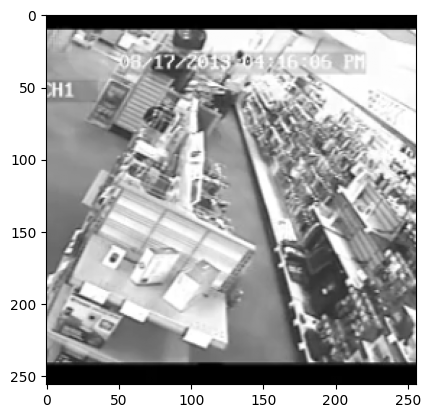

In [ ]:
import matplotlib.pyplot as plt

if torch.cuda.is_available():
    device = "cuda"
else:
    device = "cpu"

print(device)

start_sec = 0
end_sec = start_sec + clip_duration

!ls

video = EncodedVideo.from_path("./DCSASS Dataset/Shoplifting/Shoplifting001_x264.mp4/Shoplifting001_x264_19.mp4")
video_data = video.get_clip(start_sec=start_sec, end_sec=end_sec)
video_data = transform(video_data)
inputs = video_data["video"]

device = "cpu"

# Check a frame ...
print(inputs[0].shape)
print(inputs[1].shape)
plt.imshow(inputs[0][0][0].to("cpu"), cmap="gray")
plt.plot()

inputs = [i.to(device)[None, ...] for i in inputs]
model = model.to(device)

# Slowfast forward propagation
outputs = model(inputs)

print(outputs.shape)


In [ ]:
import torch.nn as nn

class CustomClassifier(nn.Module):
    def __init__(self, input_dim, hidden_dims, num_classes=2):
        super(CustomClassifier, self).__init__()

        layers = []
        prev_dim = input_dim

        for dim in hidden_dims:
            layers.extend([
                nn.Linear(prev_dim, dim),
                nn.ReLU(),
                nn.Dropout(0.5)
            ])
            prev_dim = dim

        layers.append(nn.Linear(prev_dim, num_classes))

        self.classifier = nn.Sequential(*layers)

    def forward(self, x):
        return self.classifier(x)

In [ ]:
num_classes = 2 # [prob shoplifting, prob NOT shoplifting]
slowfast_out = model.blocks[-1].proj.out_features
print(slowfast_out)

fine_tune = CustomClassifier(slowfast_out, [512, 128], num_classes)

400


In [ ]:
from torch.utils.data import Dataset, DataLoader
import pandas as pd
import os
import matplotlib.pyplot as plt

import torch.share

start_sec = 0
end_sec = start_sec + clip_duration

class VideoDataset(Dataset):
    def __init__(self, video_folder, label_csv, transform=None, clip_duration=2):
        self.video_folder = video_folder
        self.data = pd.read_csv(label_csv, header=None, names=['Name', 'Type', 'Label'])
        self.data = self.data.drop(columns=['Type'])
        self.transform = transform
        self.clip_duration = clip_duration  # Duration of video clip in seconds

    def __len__(self):
        return len(self.data)

    def __getitem__(self, idx):
        # Get video path and label
        row = self.data.iloc[idx]
        video_path = os.path.join(self.video_folder, row['Name'][0:19] + ".mp4/" + row['Name'] + ".mp4")
        label = row['Label']
        if label :
            label = torch.tensor([1,0])
        else :
            label = torch.tensor([0,1])

        # Load video
        video = EncodedVideo.from_path(video_path)
        # Sample clip (start at 0 for simplicity)
        video_data = video.get_clip(start_sec=start_sec, end_sec=end_sec)

        video_data = transform(video_data)['video']
        return video_data, label

dataset = VideoDataset("./DCSASS Dataset/Shoplifting", "./DCSASS Dataset/Labels/Shoplifting.csv", transform, clip_duration)

train_loader = DataLoader(dataset, batch_size=10, shuffle=True)
test_loader = DataLoader(dataset, batch_size=1, shuffle=True)

print(len(train_loader))
print(len(test_loader))

90
896


In [ ]:
import torch.optim as optim
from torch.optim import Adam
from torch.nn import CrossEntropyLoss

device = "cpu"
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
fine_tune = fine_tune.to(device)
model=model.to(device)

criterion = CrossEntropyLoss()
optimizer = Adam(fine_tune.parameters(), lr=0.001)

Epoch # 0  // Progress :  0.011111111111111112 % // Loss : 0.9493681192398071
Epoch # 0  // Progress :  0.022222222222222223 % // Loss : 0.5149399042129517
Epoch # 0  // Progress :  0.03333333333333333 % // Loss : 0.9446837306022644
Epoch # 0  // Progress :  0.044444444444444446 % // Loss : 0.22352738678455353
Epoch # 0  // Progress :  0.05555555555555555 % // Loss : 0.5856388807296753
Epoch # 0  // Progress :  0.06666666666666667 % // Loss : 0.2736075520515442
Epoch # 0  // Progress :  0.07777777777777778 % // Loss : 0.2624114453792572
Epoch # 0  // Progress :  0.08888888888888889 % // Loss : 0.8763402104377747
Epoch # 0  // Progress :  0.1 % // Loss : 0.5404539704322815
Epoch # 0  // Progress :  0.1111111111111111 % // Loss : 1.729564905166626
Epoch # 0  // Progress :  0.12222222222222222 % // Loss : 0.2917574644088745
Epoch # 0  // Progress :  0.13333333333333333 % // Loss : 0.5109536051750183
Epoch # 0  // Progress :  0.14444444444444443 % // Loss : 0.4783829152584076
Epoch # 0  //

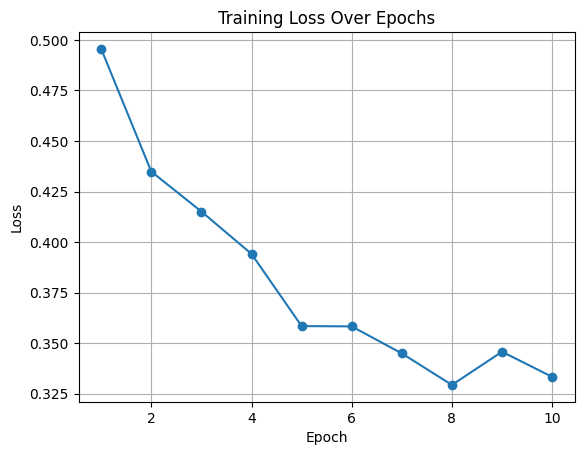

In [ ]:
torch.cuda.empty_cache()

# Initialize a list to store the running loss values
epoch_losses = []
num_epochs = 10

for epoch in range(num_epochs):
    model.eval()
    fine_tune.train()
    running_loss = 0.0

    i = 0

    for inputs, labels in train_loader:
        i += 1
        slow_pathway = inputs[0].to(device)
        fast_pathway = inputs[1].to(device)
        labels = labels.to(device)
        outputs = model([slow_pathway, fast_pathway])

        classification = fine_tune(outputs)

        optimizer.zero_grad()
        loss = criterion(classification, torch.reshape(labels,classification.shape).float())
        loss.backward()
        optimizer.step()

        running_loss += loss.item()
        print("Epoch #",epoch, " // Progress : ",i/len(train_loader), "% // Loss :", loss.item())

    # Calculate the average loss for this epoch and store it
    epoch_loss = running_loss / len(train_loader)
    epoch_losses.append(epoch_loss)

    print(f"Epoch {epoch + 1}/{num_epochs}, Loss: {epoch_loss}")

# Plot the running loss after the training loop
plt.plot(range(1, num_epochs + 1), epoch_losses, marker='o')
plt.title('Training Loss Over Epochs')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.grid(True)
plt.show()

In [ ]:
# torch.save(fine_tune.state_dict(), 'fine_tune_model.pth')
# fine_tune.load_state_dict(torch.load('fine_tune_model.pth'))

<ipython-input-9-69334ddb2cb5>:2: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  fine_tune.load_state_dict(torch.load('fine_tune_model.pth'))


<All keys matched successfully>

In [ ]:
import torch

device = "cuda" if torch.cuda.is_available() else "cpu"
# device="cpu"

model.to(device)
fine_tune.to(device)

model.eval()
fine_tune.eval()

num_tests = 100
correct_positive = 0
correct_negative = 0
test = 0
false_positive = 0
false_negative = 0


for inputs, labels in test_loader:
    slow_pathway = inputs[0].to(device)
    fast_pathway = inputs[1].to(device)
    labels = labels.to(device)
    outputs = model([slow_pathway, fast_pathway])
    classification = fine_tune(outputs)

    shoplifting_label = bool(labels[0][0])
    classification_label = bool(classification[0][0] > -1) # treshold technique

    correct_positive += shoplifting_label and classification_label
    correct_negative += not shoplifting_label and not classification_label
    false_positive += not shoplifting_label and classification_label
    false_negative += shoplifting_label and not classification_label

    print(test+1,shoplifting_label, classification_label, " // ACCURACY TRACKING : ", correct_positive, correct_negative, false_positive, false_negative)

    test += 1
    if test == 99:
      break

1 False False  // ACCURACY TRACKING :  0 1 0 0
2 False False  // ACCURACY TRACKING :  0 2 0 0
3 False False  // ACCURACY TRACKING :  0 3 0 0
4 False False  // ACCURACY TRACKING :  0 4 0 0
5 False False  // ACCURACY TRACKING :  0 5 0 0
6 False False  // ACCURACY TRACKING :  0 6 0 0
7 True True  // ACCURACY TRACKING :  1 6 0 0
8 False False  // ACCURACY TRACKING :  1 7 0 0
9 False False  // ACCURACY TRACKING :  1 8 0 0
10 False True  // ACCURACY TRACKING :  1 8 1 0
11 False False  // ACCURACY TRACKING :  1 9 1 0
12 False False  // ACCURACY TRACKING :  1 10 1 0
13 False False  // ACCURACY TRACKING :  1 11 1 0
14 False False  // ACCURACY TRACKING :  1 12 1 0
15 False False  // ACCURACY TRACKING :  1 13 1 0
16 False False  // ACCURACY TRACKING :  1 14 1 0
17 False False  // ACCURACY TRACKING :  1 15 1 0
18 False False  // ACCURACY TRACKING :  1 16 1 0
19 True True  // ACCURACY TRACKING :  2 16 1 0
20 False True  // ACCURACY TRACKING :  2 16 2 0
21 False False  // ACCURACY TRACKING :  2 17 2